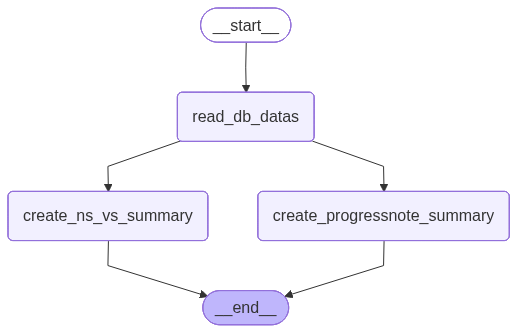

In [2]:
from src.api.medical.graphs import medical_graph


medical_graph.workflow

# 경과기록 요약


In [14]:
from sqlalchemy import select
from sqlalchemy.orm import load_only
from src.core.db import get_db
from src.models.progressnote import ProgressNote
from src.utils.format_util import hm_to_time, ymd_to_date


histories: list[str] = []
async for db in get_db():
  result = await db.scalars(
      select(ProgressNote)
      .where(ProgressNote.gubun == 'A')
      .order_by(ProgressNote.ymd.desc())
      .offset(0)
      .limit(30)
      .options(load_only(ProgressNote.auto, ProgressNote.ymd, ProgressNote.time, ProgressNote.progress))
  )

  histories.extend([
      f"**일시**: {ymd_to_date(r.ymd)} {hm_to_time(r.time)}\n**경과기록**: {r.progress}"
      for r in result
  ])


progressnote_history_text = "\n\n---\n".join(histories)

2025-11-04 17:32:29,332 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-11-04 17:32:29,333 INFO sqlalchemy.engine.Engine SELECT progressnote.prog_auto, progressnote.prog_ymd, progressnote.prog_time, progressnote.prog_progress 
FROM progressnote 
WHERE progressnote.prog_gubun = %s ORDER BY progressnote.prog_ymd DESC 
 LIMIT %s, %s
2025-11-04 17:32:29,334 INFO sqlalchemy.engine.Engine [cached since 425.1s ago] ('A', 0, 30)
2025-11-04 17:32:29,336 INFO sqlalchemy.engine.Engine ROLLBACK
2025-11-04 17:32:29,333 INFO sqlalchemy.engine.Engine SELECT progressnote.prog_auto, progressnote.prog_ymd, progressnote.prog_time, progressnote.prog_progress 
FROM progressnote 
WHERE progressnote.prog_gubun = %s ORDER BY progressnote.prog_ymd DESC 
 LIMIT %s, %s
2025-11-04 17:32:29,334 INFO sqlalchemy.engine.Engine [cached since 425.1s ago] ('A', 0, 30)
2025-11-04 17:32:29,336 INFO sqlalchemy.engine.Engine ROLLBACK


In [ ]:
from langchain.agents import create_agent
from langchain.messages import HumanMessage

from src.api.medical.dto import ProgressNoteResult
from src.constants import llm_models

agent = create_agent(
    model=llm_models.gemini_flash_lite,
    response_format=ProgressNoteResult,
    system_prompt="당신은 의사입니다. 환자의 경과기록을 가지고 필요한 정보를 입력합니다.")

response = agent.invoke({
    "messages": [HumanMessage(content=progressnote_history_text)]
})

print(response['structured_response'])

summary='2024-11-30 10:53:00 기록에 따르면, 환자는 식사 시 소화 불량을 호소하며 체중 1.5kg 증량, 손떨림 증상 거의 없음, 계단 오르기 및 push up 시 근력 약화 느낌을 보고했습니다. 이는 MMZ 20mg 복용 5주차에 갑상선 기능 저하증 상태 확인 필요성을 시사합니다. 혈액 검사 결과 확인 후 독감 접종 가능 여부를 평가하기로 했으며, 접종 시 발생 가능한 부작용(목 이물감 및 통증, 급격한 체중 변화, 두근거림)에 대해 설명했습니다. TFT 결과 확인 후 MMZ 용량 조절이 필요하며, 금요일 외래에서 검사 결과 및 약물 조절을 위해 추적 관찰하기로 했습니다. 2024-11-22 09:23:00 기록에서는 혈액 검사 결과 확인 및 설명이 이루어졌으며, 속불편감, 가려움, 두근거림, 인후통 등의 증상에 대한 확인이 있었습니다. TFT 결과는 Free T₄ 1.42, T3 1.67, TSH ▼0.01, TSH R Ab (+)로, MMZ 10mg을 TSH 정상화될 때까지 유지하기로 했습니다. 다음 혈액 검사는 12/19 예정입니다. 2024-11-19 11:07:00 기록에서는 환자가 전북대병원 ER 입원 후 퇴원했으며, 우울증, 자해 병력이 있고 최근 교우 관계 문제로 소외감을 느끼는 등 스트레스 요인이 있었습니다. 동의 입원 후 밝은 모습을 보였으나 퇴원을 원했으며, 보호자 동의 하에 퇴원했습니다. 2024-11-19 13:05:00 기록에서는 환자가 이전 약이 더 좋다고 하며 활동 및 수면에 문제가 없으나 머리 불편감은 여전하다고 하였고, 듀로셉톨(품절)에서 드록틴으로 변경되었습니다. 2024-11-19 15:19:00 기록에서는 환자가 약을 안 먹으면 답답하고 숨막히며 심장이 빨리 뛰는 공황장애 증상을 호소하여 알프람 0.25 PRN이 추가되었습니다.' main_diagnosis=[] chief_complaint='소화 불량, 근력 약화, 우울감, 불안감, 공황 증상' soap=SOAP(subjective='식사 시 소화

In [51]:
from typing import cast
from IPython.display import JSON, display
res = cast(ProgressNoteResult, response['structured_response'])

display(JSON(res.model_dump_json()))

d:\Apps\medical-ai\medical_ai_server\.venv\Lib\site-packages\IPython\core\display.py:636: UserWarning: JSON expects JSONable dict or list, not JSON strings
  warnings.warn("JSON expects JSONable dict or list, not JSON strings")


<IPython.core.display.JSON object>

# 간호기록